In [1]:
import os
import tensorflow as tf
import keras

2023-01-21 18:24:53.983990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-21 18:24:54.434066: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-21 18:24:54.490145: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-21 18:24:54.490240: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
flickr_captions = './flickr8k/captions.txt'
flickr_images = './flickr8k/images'

jpgs = os.listdir(flickr_images)
print('Number of jpg files: ', len(jpgs))

Number of jpg files:  8091


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_csv(dir):
    description = dict()
    text = pd.read_csv(dir, delimiter=',',header=None, names=["filename","index","caption"])
    text = text.iloc[1:,:]
    df = text[text.iloc[:,2].notnull()]
    print(df.ilo[:5,:])
    return df

In [4]:
from collections import Counter 

file = open(flickr_captions,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split(','):
    #print(line)
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

#df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])
df_txt = pd.read_csv(flickr_captions)

uni_filenames = np.unique(df_txt.image.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.image.values).values())

The number of unique file names : 8091
The distribution of the number of captions for each image:


Counter({5: 8091})

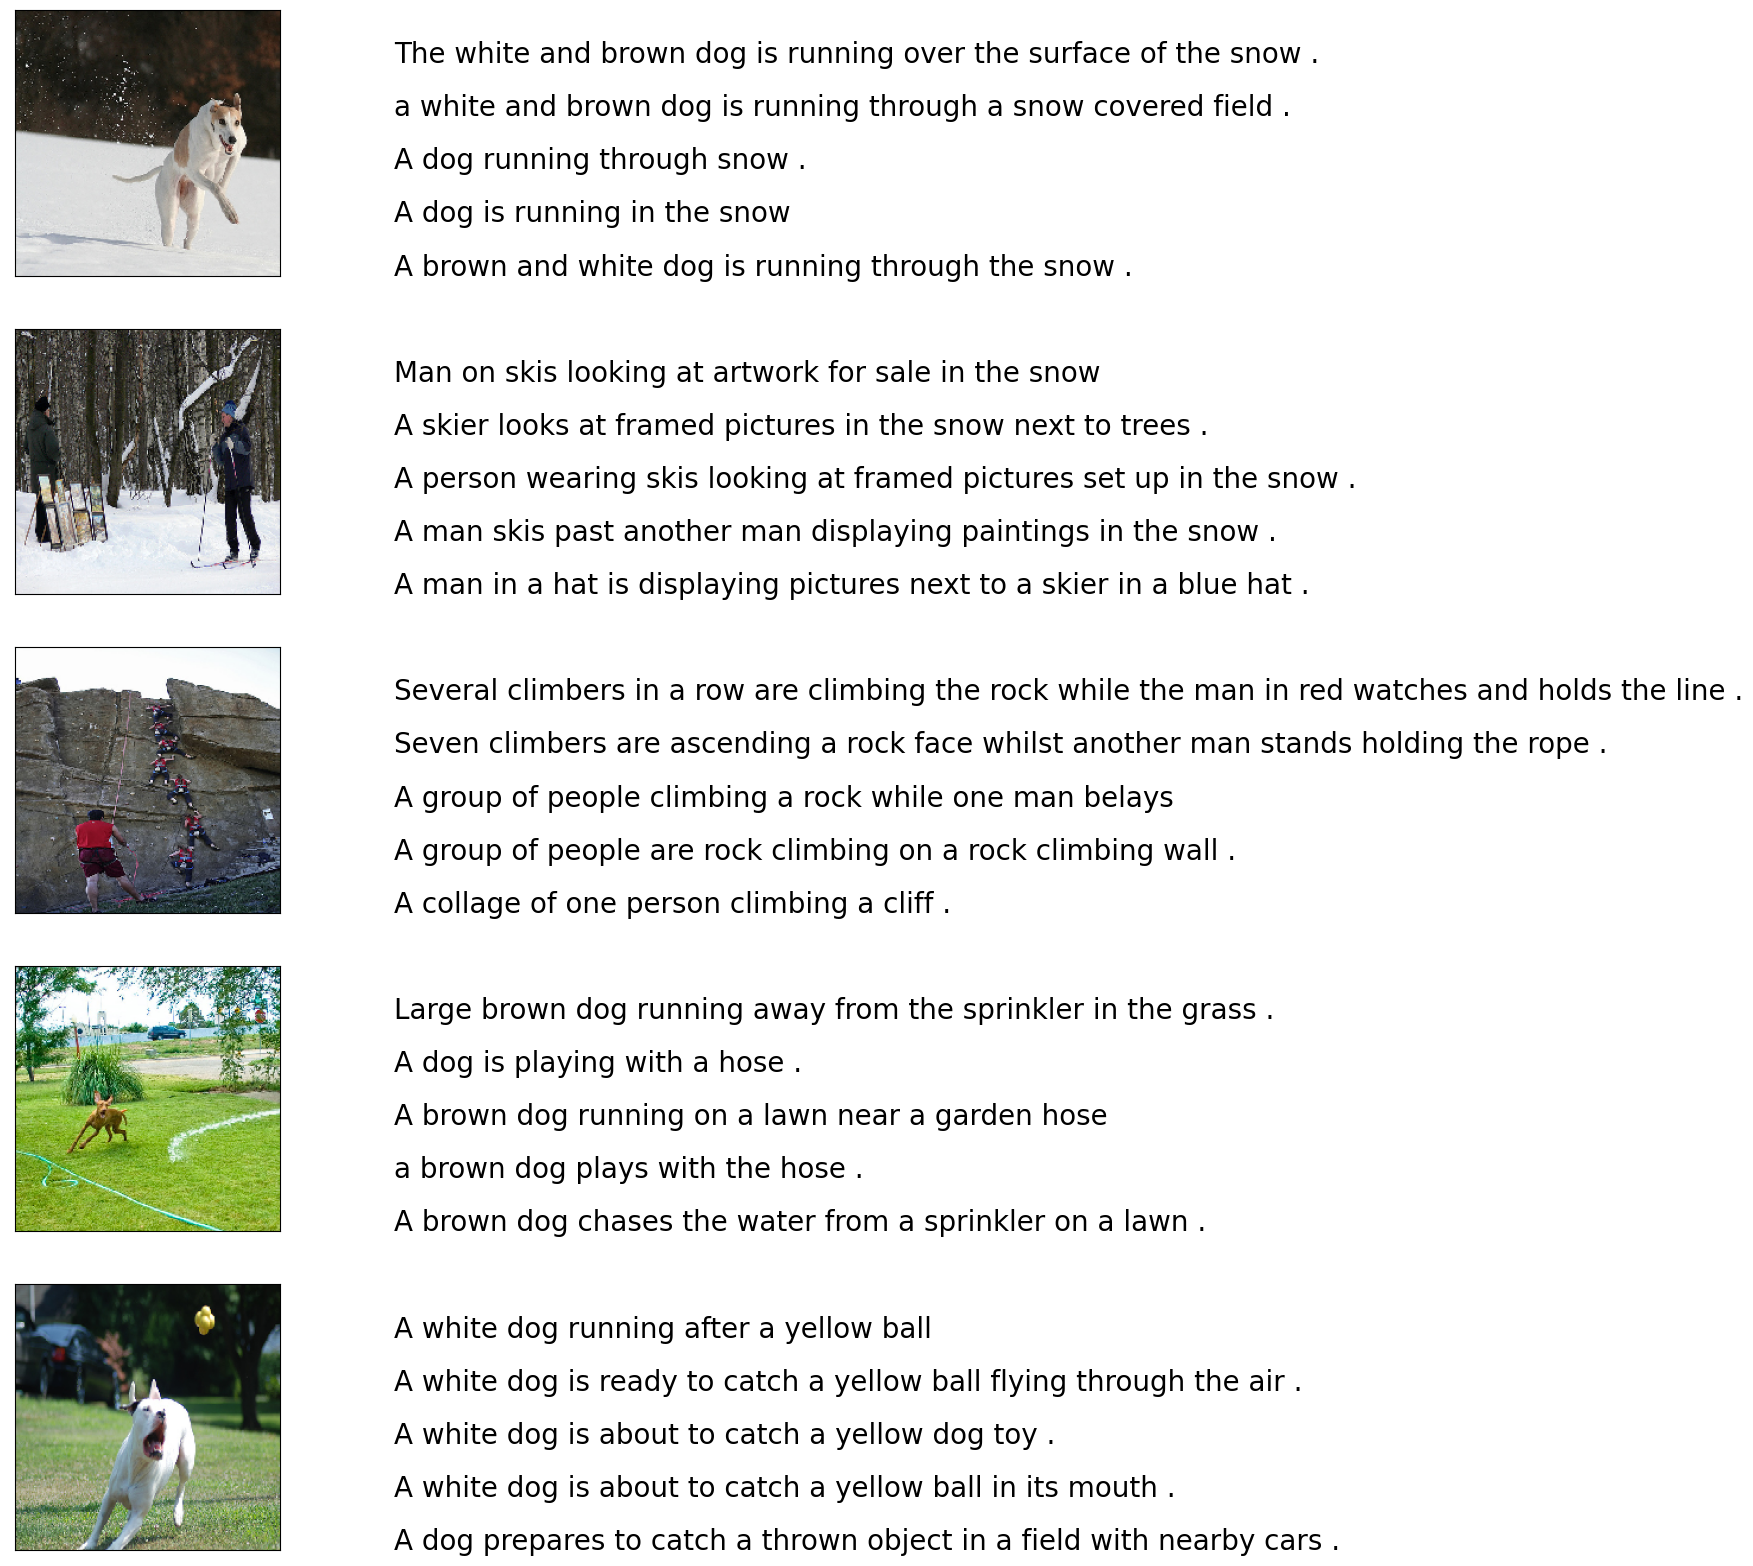

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:10+npic]:
    filename = flickr_images + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["image"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [6]:
def df_word(df_txt):
    vocabulary = []
    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,1]
        vocabulary.extend(temp.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 9630


,word,count
0,a,40319
1,.,36577
2,A,22667


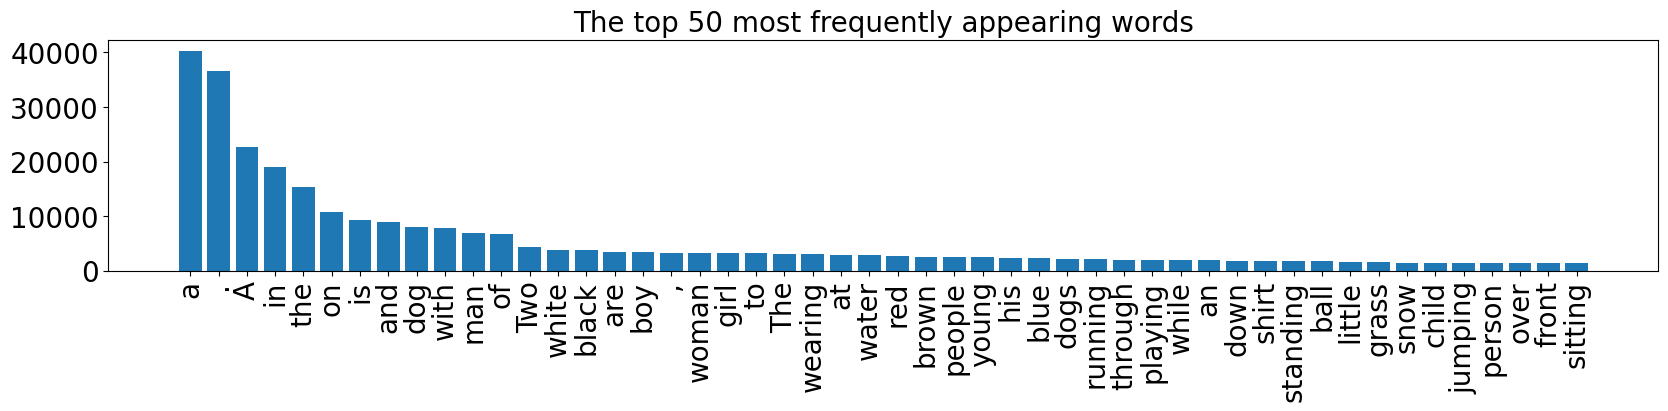

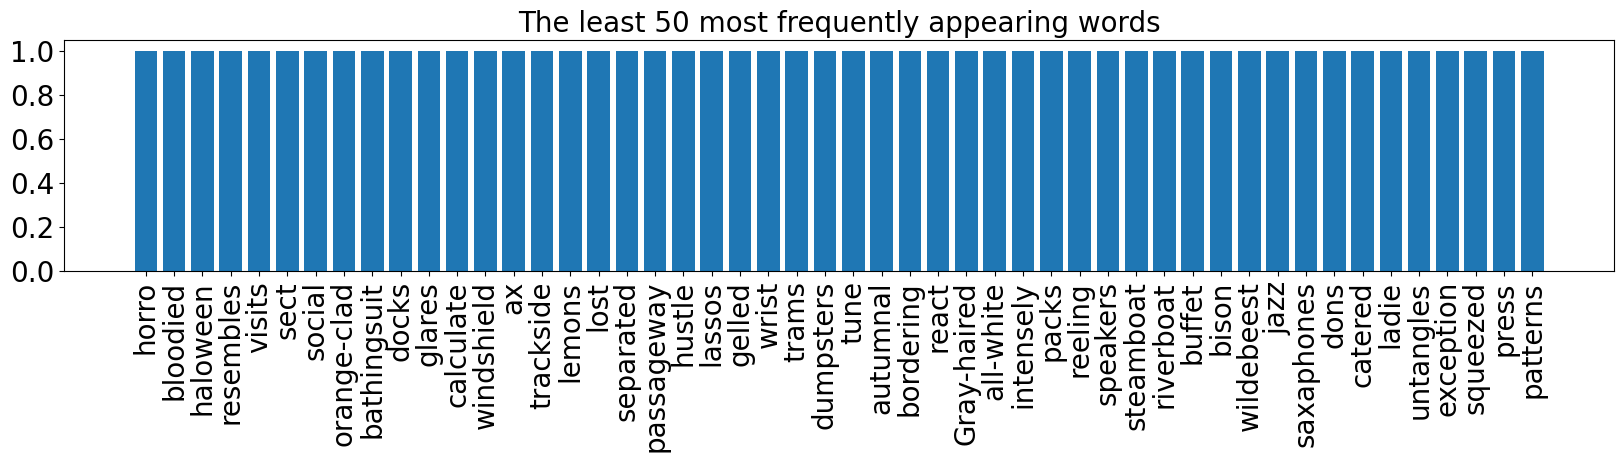

In [7]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [8]:
import string

def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [9]:

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

Vocabulary Size: 9630


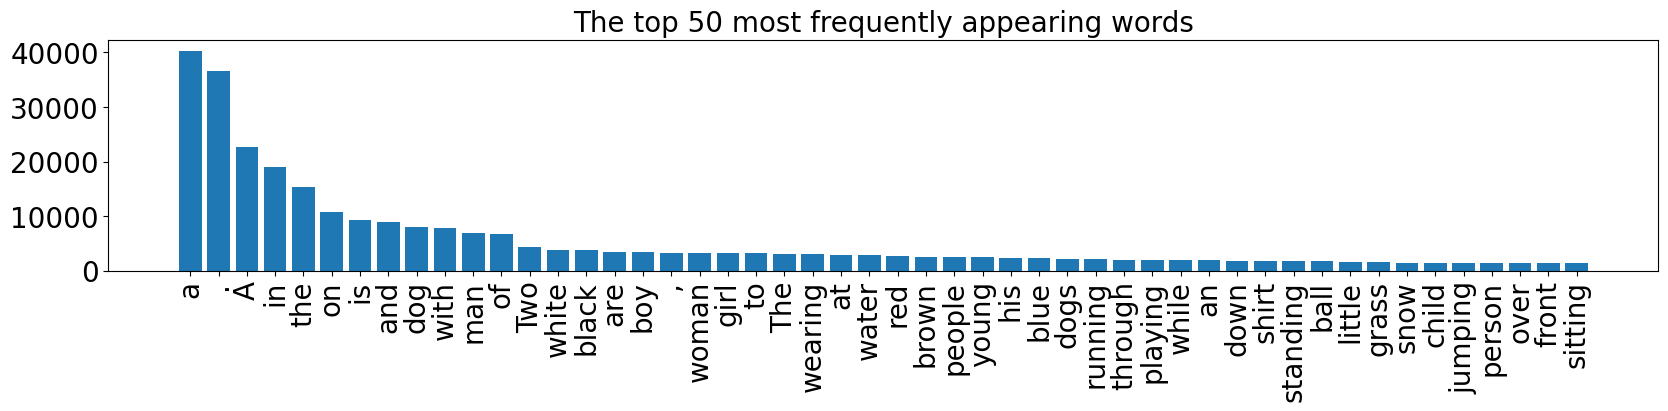

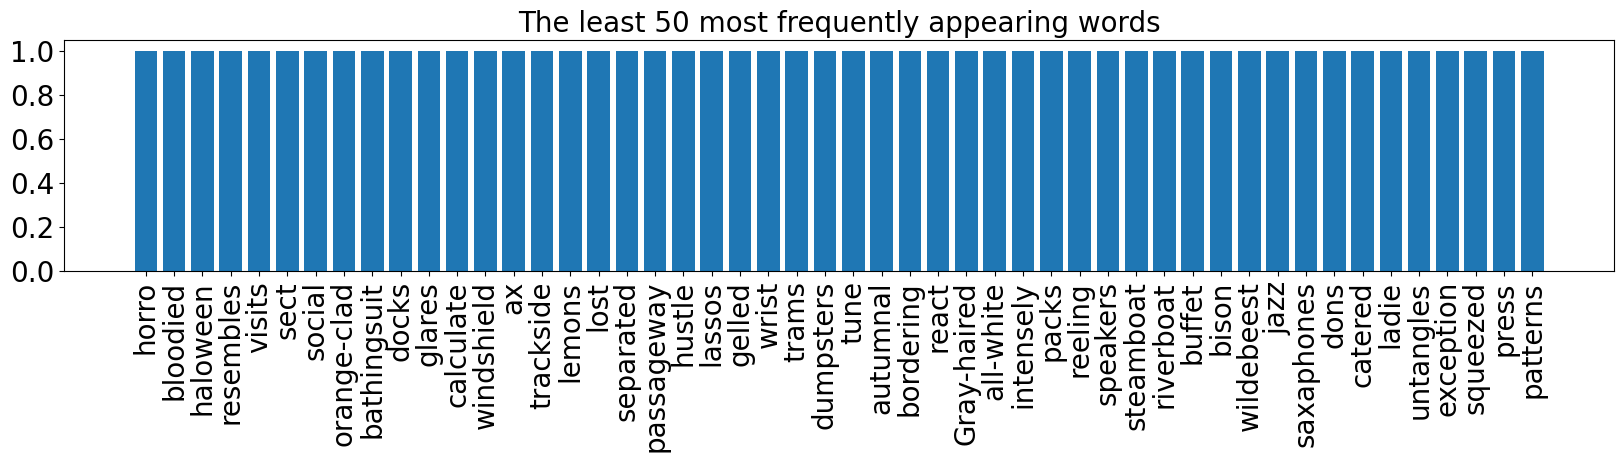

In [10]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [11]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [12]:
from keras.applications import VGG16

modelvgg = VGG16(include_top=True,weights=None)
## load the locally saved weights 
#modelvgg.load_weights("imagenet")
modelvgg.summary()

2023-01-21 18:25:08.544050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-21 18:25:08.544467: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-21 18:25:08.544768: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-21 18:25:08.544870: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-21 18:25:08.575103: W tensorf

: 

: 

In [ ]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
## show the deep learning model
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
import progressbar

images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
with progressbar.ProgressBar(max_value=len(jpgs)) as bar:
    for i,name in enumerate(jpgs):
        # load an image from file
        filename = flickr_images + '/' + name
        image = load_img(filename, target_size=target_size)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        nimage = preprocess_input(image)
        y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
        images[name] = y_pred.flatten()
        bar.update(i)
    #print(i,filename)

2023-01-21 18:24:19.658208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-21 18:24:20.072671: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-21 18:24:20.132007: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-21 18:24:20.132079: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

NameError: name 'jpgs' is not defined

In [ ]:
dimages, keepindex = [],[]
nd=(df_txt0["index"].values)
b = [(int(i)==0) for i in nd]
#for i in nd:
 #   print(int(i)==0)
#df_txt0 = df_txt0.loc[b,: ]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]

for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)
print(df_txt0["index"][:5])